In [1]:
MDtrajs_dir="./MDtrajs/"
Featurization_dir="./Featurization/"
GMRQ_dir="./GMRQ/"
MicroMSM_dir='./MicroMSM/'
MacroMSM_dir='./MacroMSM/'

topfile = MDtrajs_dir + "ala2.pdb"

## Construction and Validation of Microstate MSM

In [2]:
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
from msmbuilder.decomposition import tICA
from msmbuilder.msm import MarkovStateModel
from msmbuilder.cluster import KMeans, MiniBatchKMeans, KCenters

In [ ]:
ftrajs = np.load(Featurization_dir + 'ftrajs.npy', allow_pickle=True)

# tICA: imensionality reduction
tica = tICA(n_components=3, lag_time=2, kinetic_mapping=True)
tica_trajs = tica.fit_transform(ftrajs)
np.save(MicroMSM_dir + 'tica_trajs.npy', tica_trajs)

# K-Centers: geometric clustering
cluster = KCenters(n_clusters=800, random_state=42)
clustered_trajs = cluster.fit_transform(tica_trajs)
np.save(MicroMSM_dir + 'clustered_trajs.npy', clustered_trajs)

In [9]:
# Construct the microstate MSM
msm = MarkovStateModel(n_timescales=10, lag_time=100, ergodic_cutoff='off',
                           reversible_type='transpose', verbose=False)
msm.fit(clustered_trajs)

# Generate the microstate TPM
micro_TPM = msm.transmat_

# Find the most populated 8 microstates
states_idx = np.argsort(msm.populations_)[:-9:-1]

np.save(MicroMSM_dir + '100_lt_micro_TPM.npy', micro_TPM)    
np.savetxt(MicroMSM_dir + 'states_idx.txt', states_idx, fmt='%d')    

In [12]:
def bootstrapMSM(trajs, lagtime, n_timescales, n_RP, RP_idx, n_states, num_samples_per_run):
    bootstrap_indices = np.random.choice(range(len(trajs)), 
                                         size=num_samples_per_run, replace=True)
    bootstrap_trajs = [trajs[i] for i in bootstrap_indices]
    
    states_set = set(np.concatenate(bootstrap_trajs))
    reference_set = set(np.arange(n_states))
    miss_states_idx = sorted(list(reference_set - states_set))
    
    bootstrap_ITS = np.zeros((len(lagtime), n_timescales))
    bootstrap_RP = np.zeros((len(lagtime), n_RP))
            
    for i in range(len(lagtime)):
        msm = MarkovStateModel(n_timescales=n_timescales, lag_time=lagtime[i], ergodic_cutoff='off', 
                               reversible_type='transpose', verbose=False)
        msm.fit(bootstrap_trajs)        
        bootstrap_ITS[i] = msm.timescales_
        RP_all = np.diag(msm.transmat_).tolist()
        if len(miss_states_idx) != 0:
            for index in miss_states_idx:
                RP_all.insert(index, 0)
        bootstrap_RP[i] = np.array(RP_all)[RP_idx]
    return bootstrap_ITS, bootstrap_RP

def CK_test(lag, TPM, delta_t, length=250):
    n_micro = len(TPM)
    TPM_micro = np.zeros((length//lag, n_micro, n_micro))
    TPM_time = np.zeros(length//lag)
    TPM_micro[0] = TPM
    for i in range(len(TPM_micro)):
        TPM_micro[i] = np.linalg.matrix_power(TPM_micro[0], i+1)
        TPM_time[i] = lag * (i+1) * delta_t 
    return TPM_time, TPM_micro

In [4]:
num_runs = 50
num_samples_per_run = 100
n_timescales = 10
n_RP = 8
lagtime = np.arange(1,501)
delta_t = 0.1

bootstrap_ITS = np.zeros((num_runs, len(lagtime), n_RP))
bootstrap_RP = np.zeros((num_runs, len(lagtime), n_timescales))

for run in range(num_runs):
    bootstrap_ITS[run], bootstrap_RP[run] = bootstrapMSM(trajs=clustered_trajs, lagtime=lagtime,
                                                         n_timescales=n_timescales, n_RP=n_RP, 
                                                         RP_idx=states_idx, n_states=800,
                                                         num_samples_per_run=num_samples_per_run)
np.save(MicroMSM_dir + "bootstrap_ITS.npy",  bootstrap_ITS)
np.save(MicroMSM_dir + "bootstrap_RP.npy",  bootstrap_RP)

In [ ]:
# As an alternative of the cell above
# Use parallel to accelerate bootstrapping (not necessary)

num_runs = 50
num_samples_per_run = 100
n_timescales = 10
n_RP = 8
lagtime = np.arange(1,501)
delta_t = 0.1

bootstrap_ITS = np.memmap(MicroMSM_dir + "bootstrap_ITS.npy", dtype=np.float64, 
                          mode="w+", shape=(num_runs, len(lagtime), n_timescales))
bootstrap_RP = np.memmap(MicroMSM_dir + "bootstrap_RP.npy", dtype=np.float64, 
                          mode="w+", shape=(num_runs, len(lagtime), n_RP))

def Process(run):
    result1, result2 = bootstrapMSM(trajs=clustered_trajs, lagtime=lagtime, 
                                    n_timescales=n_timescales, n_RP=n_RP, 
                                    RP_idx=states_idx, n_states=800, 
                                    num_samples_per_run=num_samples_per_run)
    bootstrap_ITS[run] = result1
    bootstrap_RP[run] = result2
    
Parallel(n_jobs=5)(delayed(Process)(run = i) for i in range(num_runs))

# Load the generated bootstrap_ITS and bootstrap_RP
bootstrap_RP = np.array(np.memmap(MicroMSM_dir + "bootstrap_RP.npy", dtype=np.float64, 
                          mode="r", shape=(num_runs, len(lagtime), n_RP)))
bootstrap_ITS = np.array(np.memmap(MicroMSM_dir + "bootstrap_ITS.npy", dtype=np.float64, 
                          mode="r", shape=(num_runs, len(lagtime), n_timescales)))

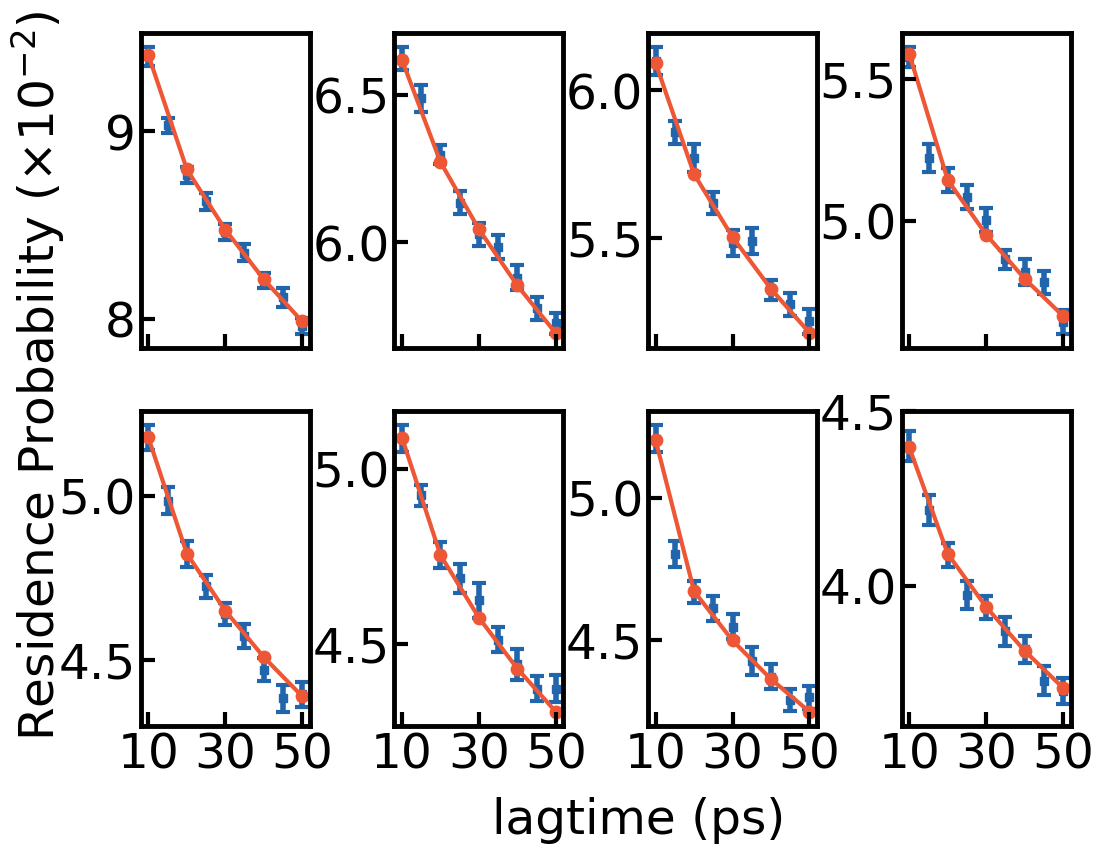

In [16]:
from matplotlib import pyplot as plt

micro_TPM = np.load(MicroMSM_dir + '100_lt_micro_TPM.npy')
list_indice = np.loadtxt(MicroMSM_dir + 'states_idx.txt', dtype=int)   
color_1 = '#2166ac'
color_2 = '#ed5736'
RP_100 = bootstrap_RP * 100
RP_mean = np.mean(RP_100, axis=0)
RP_std = np.std(RP_100, axis=0)

# generate the TPM predicted from MSM
MSM_time, MSM_TPM = CK_test(lag=100, TPM=micro_TPM, delta_t=0.1, length=500)

# CK test
plt.rcParams['font.size'] = 35
fig, axes = plt.subplots(2, 4, figsize=(12,9), sharex=True)
for i in range(8):
    ax = axes[int(i/4), int(i%4)]
    ax.errorbar(np.arange(10,51,5), RP_mean[99::50,i], yerr=RP_std[99::50,i],
                fmt='s', capsize=5, capthick=3,
                elinewidth=4, ecolor=color_1, color=color_1,
                zorder=0, linewidth=3)
    ax.plot(MSM_time, MSM_TPM[:,list_indice[i],list_indice[i]] * 100, linewidth=3, 
            color=color_2, zorder=1)
    ax.scatter(MSM_time, MSM_TPM[:,list_indice[i],list_indice[i]] * 100, s=80,
               c=color_2, zorder=1)
    ax.tick_params(axis='both', direction='in', width=3, length=10)
    ax.set_xticks(ticks=[10,30,50], labels=[10,30,50])
#     ax.text(5, 0.135, 'State %d'%(i+1), ha='right',va='top')
    for spine in ax.spines.values():
        spine.set_linewidth(3.5)
axes[1,3].set_ylim(3.6, 4.5)       
fig.subplots_adjust(wspace=0.5, hspace=0.2)
fig.text(0.54, 0.005, 'lagtime (ps)', ha='center', va='center')
fig.text(0.04, 0.5, "Residence Probability ($\\times 10^{-2}$)", ha='center', va='center', rotation=90)
plt.errorbar([], [], yerr=[], color=color_1, label='MD', fmt='s',
             markersize=20, elinewidth=3, capsize=3, capthick=2)
plt.errorbar([], [], xerr=[], color=color_2, label='MSM', fmt='o',
             markersize=10, elinewidth=3, capsize=3)
# fig.legend(loc='center', bbox_to_anchor=(0.5, 0.95), ncol=2)
plt.savefig('./png/micro_CK.png', dpi=1000, bbox_inches='tight')
plt.show()

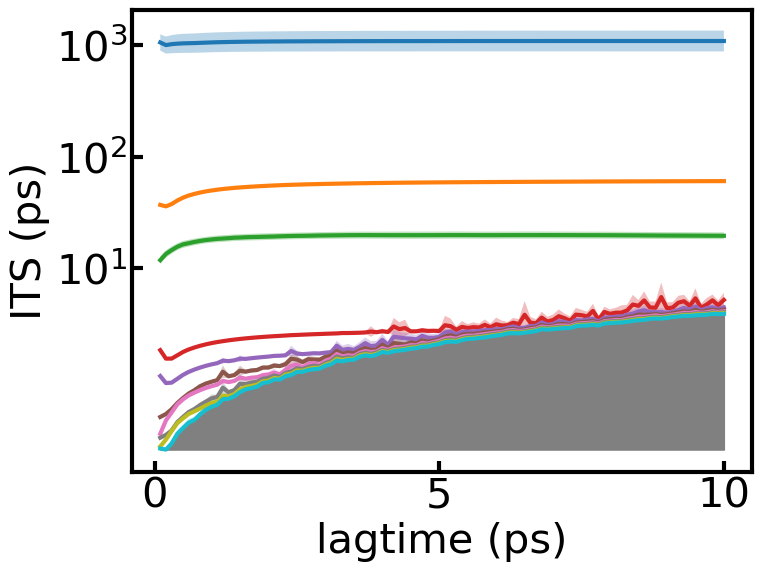

In [21]:
lagtime = np.arange(1,101,1) * delta_t
log_ITS = np.log10(bootstrap_ITS * delta_t)[:,:100,:]
ITS_mean = np.mean(log_ITS, axis=0)
ITS_std = np.std(log_ITS, axis=0)

# ITS test
plt.rcParams['font.size'] = 30
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
    ax.fill_between(lagtime, ITS_mean[:,i]-ITS_std[:,i], 
                    ITS_mean[:,i]+ITS_std[:,i], alpha=0.3)
    ax.plot(lagtime, ITS_mean[:,i], linewidth=3)
ax.fill_between(lagtime, np.ones(len(lagtime))*np.min(ITS_mean[:,-1]), ITS_mean[:,-1],color='grey')
plt.yticks([1,2,3], labels=['$10^1$', '$10^2$','$10^3$'])    
plt.xlabel('lagtime (ps)')
plt.ylabel('ITS (ps)')
ax.tick_params(axis='both', direction='in', width=3, length=8)
for spine in ax.spines.values():
    spine.set_linewidth(3)
# fig.legend(loc='center right', bbox_to_anchor=(1.28, 0.5))
# plt.savefig('./png/ITS_bt.png', dpi=900, bbox_inches='tight')
plt.show()